# Online Retail – Customer Segmentation & Recommender System
Romeo Cozac (June, 2018)
___
**The Data**: This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Goals**: Through this notebook we aim to better understand customer behaviour as well as trends in sales, and to use this information to answer business questions. We look at new customer aquisition through time and repeat purchase rates, as we want to segment customers based on how much value they are likely to bring in the future. Also, we check which products/categories each one of our segments prefer and which ones are more troublesome. Finally, we build a collaborative filtering based recommender system.
___
**1. Setup and Prerequisites**

**2. Visualizing and Exploring the Data**

## 1. Setup and Prerequisites
As a first step, we download the data under from kaggle into to the `data/` directory

In [ ]:
!kaggle datasets download -d carrie1/ecommerce-data -p data/

Next, we load the modules and dependencies used in the notebook

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats

Finally, we load the data into memory

In [319]:
df = pd.read_csv('data/data.csv', encoding = "ISO-8859-1")

## 2. Visualizing the Data

Our dataset contains the following information:
- **InvoiceNo**: *(discrete)* `string` — A unique identifier for each purchase made. <br />
  - This variable is generally numeric. When the value starts with a "C", it indicates a cancelled item. <br />
- **StockCode**: *(discrete)* `string` — A unique identifier for the product that was purchased. <br />
  - When the fields contains only letters, it indicates a type of operation instead of a product ID (ie: discount or manual adjustment)
- **Description**: *(discrete)* `string` — Name of the purchased product. <br />
  - In case of a certain operation like discounts, this field will contain additional details to what appears in "StockCode
- **Quantity**: *(continuous)* `int` — How many products were bought on this order. <br />
- **InvoiceDate**: *(continuous)* `date` — When the order was made. <br />
- **UnitPrice**: *(continuous)* `float` — Product price per unit (in pound sterling). <br />
  - This can be negative in case of a cancellation or discount
- **CustomerID**: *(discrete)* `int` — A unique identifier for the customer who made the order. <br />
- **Country**: *(discrete)* `string` — Location of the store.

In [320]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


We can see that our dataset is focused on *products* (order items) instead of orders as there are duplicate `InvoiceNo`s. This means that each row represents a unique product from an order made.

### 2.1. Data Preparation and Feature Engineering
We first cast the type of **InvoiceDate** to `datetime` and add a new field called **RowTotal**, which is the total amount paid on the entry.

In [321]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["RowTotal"] = df["Quantity"] * df["UnitPrice"]

Order based metrics (instead of order items) is also something we want to look at, so we create an aggregated DataFrame based on orders. We compute the **GrandTotal** for each order and count the number of unique products, as well as the total number of items purchased.

In [322]:
orders = df.groupby("InvoiceNo") \
    .agg({
        'StockCode':'count',
        'Quantity': 'sum',
        'RowTotal': 'sum',
        'Country': 'first',
        'InvoiceDate': 'first',
        'CustomerID': 'first'}) \
    .reset_index() \
    .rename(columns={
        'StockCode':'ProductsCount', 
        'Quantity': 'ItemsCount', 
        'RowTotal': 'GrandTotal'
    })
    
orders.head()

,InvoiceNo,ProductsCount,ItemsCount,GrandTotal,Country,InvoiceDate,CustomerID
0,536365,7,40,139.12,United Kingdom,2010-12-01 08:26:00,17850.0
1,536366,2,12,22.20,United Kingdom,2010-12-01 08:28:00,17850.0
2,536367,12,83,278.73,United Kingdom,2010-12-01 08:34:00,13047.0
3,536368,4,15,70.05,United Kingdom,2010-12-01 08:34:00,13047.0
4,536369,1,3,17.85,United Kingdom,2010-12-01 08:35:00,13047.0


### 2.2. Empty Values

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
RowTotal       541909 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


The dataset contains a little over 540,000 entries (order items). Most variables have a value 100% of the time, except for the **Description**, but especially for the **CustomerID**. It is possible the entries missing a customer ID were submited by guests (people who placed an order without creating an account).

We take a closer look at the **Description** field.

In [324]:
no_descriptions = df[df["Description"].isnull()]
no_descriptions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RowTotal
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,0.0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,0.0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0.0
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,0.0


Most rows that match this description are free items (**UnitPrice** is 0). We check if this is always the case, which indeed is.

In [325]:
print('There are %s entries with an empty "Description" and a non-zero "UnitPrice"' % sum(no_descriptions["UnitPrice"] > 0))

There are 0 entries with an empty "Description" and a non-zero "UnitPrice"


### 2.3. Basic Statistics
Knowing the smallest product price, the largest number of items purchased at once or the average sale value might be of interest. To get an accurate estimate we will exclude cancelled orders, free items and outliers (keeping ~99.7% of the values).

In [326]:
clean_transactions = df[(df["RowTotal"] > 0) & (df["StockCode"].str.contains('\d', regex=True))]
clean_transactions = clean_transactions[["Quantity", "UnitPrice", "RowTotal"]]

clean_orders = orders[orders["GrandTotal"] > 0]
clean_orders = clean_orders[["ProductsCount", "ItemsCount", "GrandTotal"]]

clean_transactions = clean_transactions[(np.abs(stats.zscore(clean_transactions)) < 3).all(axis=1)]
clean_orders = clean_orders[(np.abs(stats.zscore(clean_orders)) < 3).all(axis=1)]

In [327]:
clean_transactions.describe()

,Quantity,UnitPrice,RowTotal
count,520539.000000,520539.000000,520539.000000
mean,9.445427,3.009416,17.153683
std,21.287281,2.737098,35.895841
min,1.000000,0.040000,0.060000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,468.000000,16.130000,816.750000


Looking at *order items*:
- We are left with around 520,000 entries
- On average 9-10 items are ordered from each product. However, the median is only 4, suggesting more orders with a lower quantity and a few orders with "extreme" quantities (probably wholesalers);
- The price per unit indicates that the vendor is selling low priced items. It ranges from 4p to little over 16£, with a median close to 2£.

In [328]:
clean_orders.describe()

,ProductsCount,ItemsCount,GrandTotal
count,19478.000000,19478.000000,19478.000000
mean,21.632611,228.124191,412.976755
std,23.397583,288.844859,507.928780
min,1.000000,1.000000,0.380000
25%,6.000000,68.000000,149.685000
50%,15.000000,147.000000,301.200000
75%,28.000000,281.000000,471.165000
max,169.000000,3104.000000,5867.080000


Looking at *orders*:
- There are close to 20,000 orders in the dataset
- The order statistics as well as the mean of the "ProductsCount" and "ItemsCount" indicates that the vendor is heavily focused on bulk sales. On average, more than 20 different products are purchased on every order with an average total item count of ~230 per order.
- The average order value is little over 400£, with 75% of the orders being ~150£ or over.

### 2.4. Cancelled Orders
We want to know how many orders are cancelled.

In [329]:
cancelled_orders = orders[orders['InvoiceNo'].str.contains('C')]
cancelled_orders.head()

,InvoiceNo,ProductsCount,ItemsCount,GrandTotal,Country,InvoiceDate,CustomerID
22064,C536379,1,-1,-27.50,United Kingdom,2010-12-01 09:41:00,14527.0
22065,C536383,1,-1,-4.65,United Kingdom,2010-12-01 09:49:00,15311.0
22066,C536391,7,-132,-141.48,United Kingdom,2010-12-01 10:24:00,17548.0
22067,C536506,1,-6,-25.50,United Kingdom,2010-12-01 12:38:00,17897.0
22068,C536543,2,-3,-3.80,United Kingdom,2010-12-01 14:30:00,17841.0


Besides the **GrandTotal** the **ItemsCount** is also negative for cancelled orders. This could indicate that a new entry is created for cancellations instead of the old ones being overwritten. We wish to verify this theory.

In [330]:
aggregate_table = df.copy()
aggregate_table['count_per_customer'] = aggregate_table.groupby('CustomerID')['CustomerID'].transform('count')
aggregate_table['min_per_customer'] = aggregate_table.groupby('CustomerID')['RowTotal'].transform('min')

aggregate_table[
    (aggregate_table['count_per_customer'] == 2) 
    & (aggregate_table['min_per_customer'] < 0)
].sort_values(by=['CustomerID', 'StockCode', 'InvoiceDate']).loc[:, 'InvoiceNo':'CustomerID'].head(n=8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0
31983,C539037,22474,SPACEBOY TV DINNER TRAY,-32,2010-12-15 14:42:00,4.25,12666.0
31982,C539037,84792,ENCHANTED BIRD COATHANGER 5 HOOK,-24,2010-12-15 14:42:00,3.81,12666.0
18974,C537824,22220,CAKE STAND LOVEBIRD 2 TIER WHITE,-1,2010-12-08 14:27:00,9.95,12870.0
18975,C537824,22784,LANTERN CREAM GAZEBO,-1,2010-12-08 14:27:00,4.95,12870.0
283862,561811,22456,NATURAL SLATE CHALKBOARD LARGE,18,2011-07-29 15:12:00,4.25,13106.0
288420,C562160,22456,NATURAL SLATE CHALKBOARD LARGE,-4,2011-08-03 11:50:00,4.25,13106.0


For ease, order items were filtered down to customers with only 2 row items and at least 1 negative row item. We notice several interesting cases:
- It is confirmed that indeed, new items are added in case of a cancellation instead of old rows being updated;
- Partial cancellations are possible, since the quantities don't always match up;
- Not every cancellation has a matching pair (these could be cancellations of orders placed before 01/12/2010).

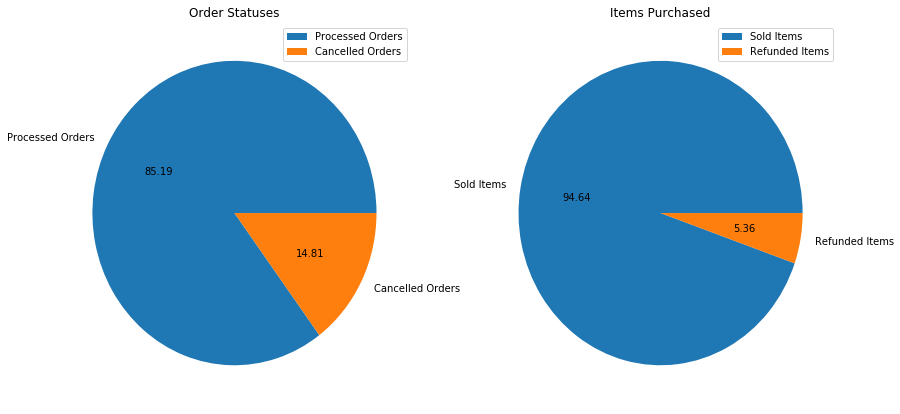

In [331]:
orders_count = pd.DataFrame({'Orders Count': [orders.shape[0] - cancelled_orders.shape[0], cancelled_orders.shape[0]]},
                             index=['Processed Orders', 'Cancelled Orders'])

total_items_count = sum(df['Quantity'])
refunded_items_count = sum(df[df['InvoiceNo'].str.contains('C')]['Quantity']) * -1
items_count = pd.DataFrame({'Items Count': [total_items_count - refunded_items_count, refunded_items_count]},
                             index=['Sold Items', 'Refunded Items'])

fig, axes = plt.subplots(1, 2)
axes[0].axis('off')
axes[1].axis('off')

orders_count.plot(kind='pie', y='Orders Count', autopct='%.2f', ax=axes[0], title='Order Statuses', figsize=(14, 7))
items_count.plot(kind='pie', y='Items Count', autopct='%.2f', ax=axes[1], title='Items Purchased', figsize=(14, 7))

Almost 15% of all orders are cancellations, but only ~5% of items are cancellend (due to partial cancellations)
### 2.5. Geolocation
We want to know how orders are distributed through each country

In [ ]:
orders.plot(column='Country', cmap='Blues', figsize=(7,14), scheme='equal_interval', legend=True)